In [1]:
import pandas as pd
import numpy as np
import os
import glob

import zipfile
import csv
import warnings
warnings.filterwarnings('ignore')
import gc
import datetime

In [2]:
survey_data = pd.read_excel('SurveyResults.xlsx',usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'])

In [3]:
survey_data.dtypes

ID                      object
Start time              object
End time                object
date            datetime64[ns]
Stress level            object
dtype: object

In [4]:
survey_data.isnull().sum()

ID              0
Start time      0
End time        0
date            0
Stress level    0
dtype: int64

In [5]:
survey_data['Start datetime'] =  pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['Start time'].map(str))
survey_data['End datetime'] =  pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['End time'].map(str))
survey_data.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

survey_data['datetime'] = survey_data['End datetime'] - survey_data['Start datetime']
survey_data['time'] = survey_data['datetime'].apply(lambda x: x.seconds/60)

In [7]:
survey_data.head()

,ID,Stress level,Start datetime,End datetime,datetime,time
0,5C,1,2020-04-15 08:00:00,2020-04-15 09:00:00,0 days 01:00:00,60.0
1,5C,1,2020-04-14 17:31:00,2020-04-14 17:58:00,0 days 00:27:00,27.0
2,E4,2,2020-04-18 15:32:00,2020-04-18 15:37:00,0 days 00:05:00,5.0
3,E4,2,2020-04-18 14:05:00,2020-04-18 14:11:00,0 days 00:06:00,6.0
4,7A,2,2020-04-18 13:52:00,2020-04-18 14:03:00,0 days 00:11:00,11.0


In [81]:
final_df = pd.DataFrame()
count = 0
print('There are total',len(glob.glob(os.path.join(r"C:\Users\shant\Downloads\2201038\Data\*\*"))),'zipfiles files in the dataset')
for i in glob.glob(os.path.join(r"C:\Users\shant\Downloads\2201038\Data\*\*")):
    with zipfile.ZipFile(i, 'r') as zip_ref:
        
        ACC = pd.read_csv(zip_ref.open('ACC.csv'))
        BVP = pd.read_csv(zip_ref.open('BVP.csv'))
        EDA = pd.read_csv(zip_ref.open('EDA.csv'))
        HR = pd.read_csv(zip_ref.open('HR.csv'))
        TEMP = pd.read_csv(zip_ref.open('TEMP.csv'))
        
        ACC['time'] = int(float(ACC.columns[0]))
        ACC['time'] = ACC['time']+ACC.index
        ACC['time'] = ACC['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
        
        def process_df(df):
            start_timestamp = df.iloc[0,0]
            sample_rate = df.iloc[1,0]
            new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
            new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
            return new_df
        
        ACC = process_df(ACC)
        BVP = process_df(BVP)
        EDA = process_df(EDA)
        HR = process_df(HR)
        TEMP = process_df(TEMP)
        
        ACC.rename({ACC.columns[0]:'X',ACC.columns[1]:'Y',ACC.columns[2]:'Z',},axis = 1,inplace = True)
        BVP.rename({BVP.columns[0]:'BVP'},axis = 1,inplace = True)
        EDA.rename({EDA.columns[0]:'EDA'},axis = 1,inplace = True)
        HR.rename({HR.columns[0]:'HR'},axis = 1,inplace = True)
        TEMP.rename({TEMP.columns[0]:'TEMP'},axis = 1,inplace = True)
        
        final = ACC.merge(BVP,on = 'datetime',how = 'outer').merge(EDA,on = 'datetime',how = 'outer').merge(HR,on = 'datetime',how = 'outer').merge(TEMP,on = 'datetime',how = 'outer')
        
        final = final.fillna(method='ffill')
        final = final.fillna(method='bfill').reset_index(drop = True)
        
        final['Stress'] = np.where(final['datetime'] > survey_data['time'].max(),2,1)
        
        final.drop_duplicates(inplace = True)
        
        final_df = final_df.append(final)
        
        count += 1
            
        gc.collect()
        
final_df.drop_duplicates(inplace = True)
final_df.to_csv('final.csv',index = False)
print('Preprocessing is done')

There are total 609 zipfiles files in the dataset
Preprocessing is done


# Assignment 2

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [44]:
#Reading the Final CSV
final = pd.read_csv('final.csv',parse_dates = ['time'])

In [45]:
final.head()

,X,Y,Z,time,datetime,BVP,EDA,HR,TEMP,Stress
0,-57.0,7.0,-30.0,2020-07-07 17:42:57,32.000000,-0.0,0.032035,81.73,30.13,1
1,-57.0,7.0,-30.0,2020-07-07 17:42:58,31.982456,-0.0,0.032035,81.73,30.13,1
2,-57.0,7.0,-31.0,2020-07-07 17:42:59,31.964912,-0.0,0.032035,81.73,30.13,1
3,-57.0,7.0,-32.0,2020-07-07 17:43:00,31.947368,-0.0,0.032035,81.73,30.13,1
4,-56.0,7.0,-31.0,2020-07-07 17:43:01,31.929825,-0.0,0.032035,81.73,30.13,1


In [46]:
#Checking Null values
final.isnull().sum()

X           0
Y           0
Z           0
time        0
datetime    0
BVP         0
EDA         0
HR          0
TEMP        0
Stress      0
dtype: int64

In [47]:
#checking duplicates
final.duplicated().sum()

0

In [48]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15621346 entries, 0 to 15621345
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X         float64       
 1   Y         float64       
 2   Z         float64       
 3   time      datetime64[ns]
 4   datetime  float64       
 5   BVP       float64       
 6   EDA       float64       
 7   HR        float64       
 8   TEMP      float64       
 9   Stress    int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.2 GB


In [49]:
final.dtypes

X                  float64
Y                  float64
Z                  float64
time        datetime64[ns]
datetime           float64
BVP                float64
EDA                float64
HR                 float64
TEMP               float64
Stress               int64
dtype: object

In [50]:
final['Stress'].value_counts()

1    11908793
2     3712553
Name: Stress, dtype: int64

<AxesSubplot:xlabel='Stress', ylabel='count'>

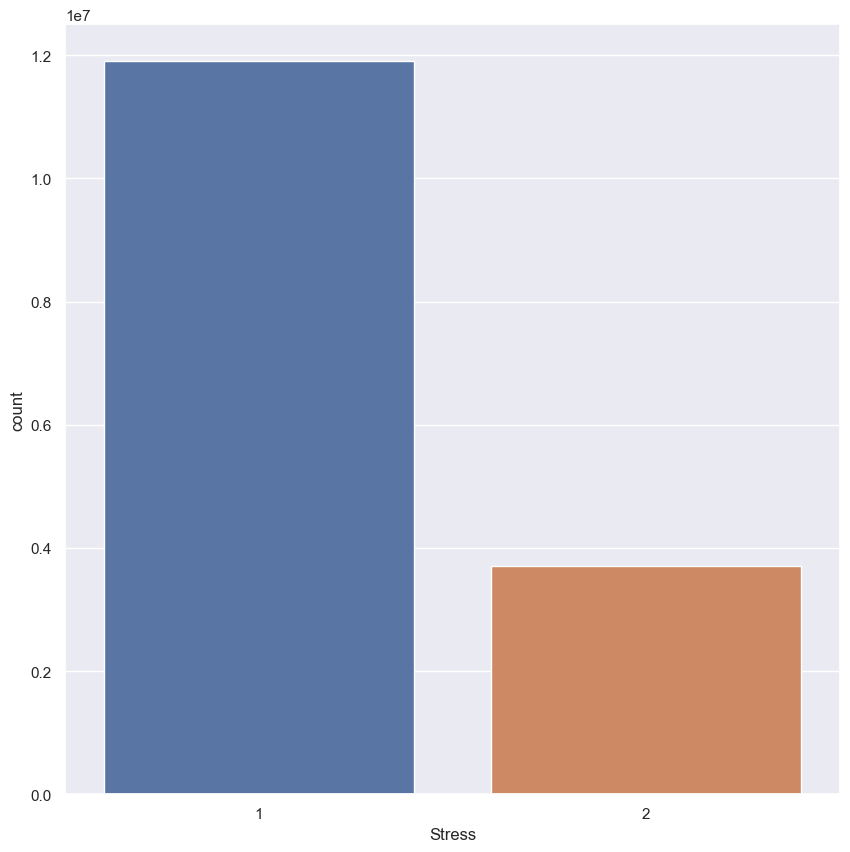

In [51]:
sns.countplot(final['Stress'])

# Handling the imbalance data

In [52]:
# Separate majority and minority classes
majority_class = final[final.Stress == 1]
minority_class = final[final.Stress == 2]

downsampled_majority_class = resample(majority_class,replace=False,n_samples=len(minority_class))
final = pd.concat([downsampled_majority_class, minority_class]).sample(frac=1).reset_index(drop = True)

In [53]:
final

,X,Y,Z,time,datetime,BVP,EDA,HR,TEMP,Stress
0,-39.0,46.0,127.0,2020-04-23 11:59:10,-inf,-81.00,0.267734,93.73,34.73,1
1,-44.0,40.0,-28.0,2020-07-13 07:47:27,-9133.970588,-0.00,0.019219,50.50,34.57,1
2,-22.0,-56.0,-3.0,2020-07-08 15:05:30,-inf,196.07,0.002563,114.00,33.37,1
3,-24.0,49.0,127.0,2020-04-16 08:25:13,2535.685185,-0.00,0.267734,93.73,35.53,2
4,57.0,-30.0,47.0,2020-05-01 11:01:21,1775.586559,1.17,0.585694,102.53,25.55,2
...,...,...,...,...,...,...,...,...,...,...
7425101,-22.0,-49.0,-8.0,2020-08-09 17:36:47,-inf,65.41,0.453591,79.00,32.84,1
7425102,-46.0,37.0,-21.0,2020-07-14 21:26:28,119.882353,15.34,10.718651,82.57,34.09,1
7425103,-46.0,37.0,-21.0,2020-07-14 21:26:28,-inf,247.32,0.019219,50.50,34.57,1
7425104,-27.0,50.0,-15.0,2020-07-14 01:03:10,-8181.042553,-0.00,0.017942,53.50,30.09,1


In [54]:
final.Stress.value_counts()

1    3712553
2    3712553
Name: Stress, dtype: int64

<AxesSubplot:xlabel='Stress', ylabel='count'>

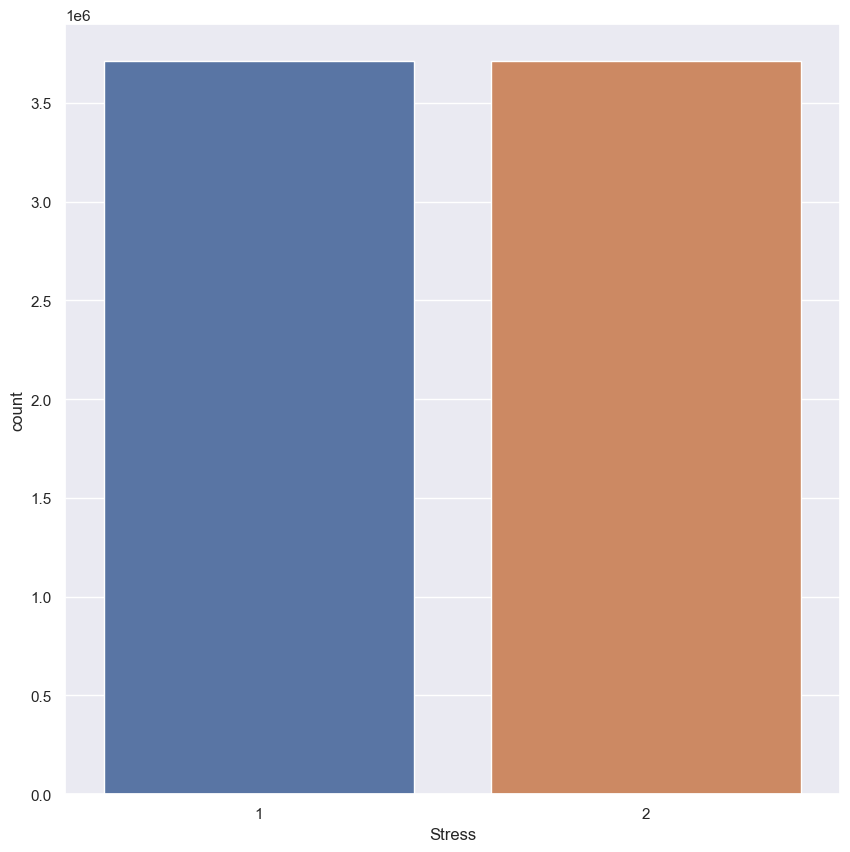

In [55]:
sns.countplot(final['Stress'])

# Correlation to determine which feature is good

In [56]:
final.corr()

,X,Y,Z,datetime,BVP,EDA,HR,TEMP,Stress
X,1.000000,0.095385,0.129495,0.437968,0.050091,-0.161865,0.527846,-0.533878,0.509631
Y,0.095385,1.000000,0.220544,0.056390,-0.078285,-0.011091,0.030032,-0.003174,0.049624
Z,0.129495,0.220544,1.000000,0.231808,-0.007016,-0.076736,0.255819,0.287827,0.330814
datetime,0.437968,0.056390,0.231808,1.000000,0.005972,-0.068866,0.539984,-0.254006,0.658407
BVP,0.050091,-0.078285,-0.007016,0.005972,1.000000,-0.069157,-0.004556,-0.014404,-0.001153
EDA,-0.161865,-0.011091,-0.076736,-0.068866,-0.069157,1.000000,-0.007432,0.178610,0.118964
HR,0.527846,0.030032,0.255819,0.539984,-0.004556,-0.007432,1.000000,-0.321892,0.694069
TEMP,-0.533878,-0.003174,0.287827,-0.254006,-0.014404,0.178610,-0.321892,1.000000,-0.206755
Stress,0.509631,0.049624,0.330814,0.658407,-0.001153,0.118964,0.694069,-0.206755,1.000000


<AxesSubplot:>

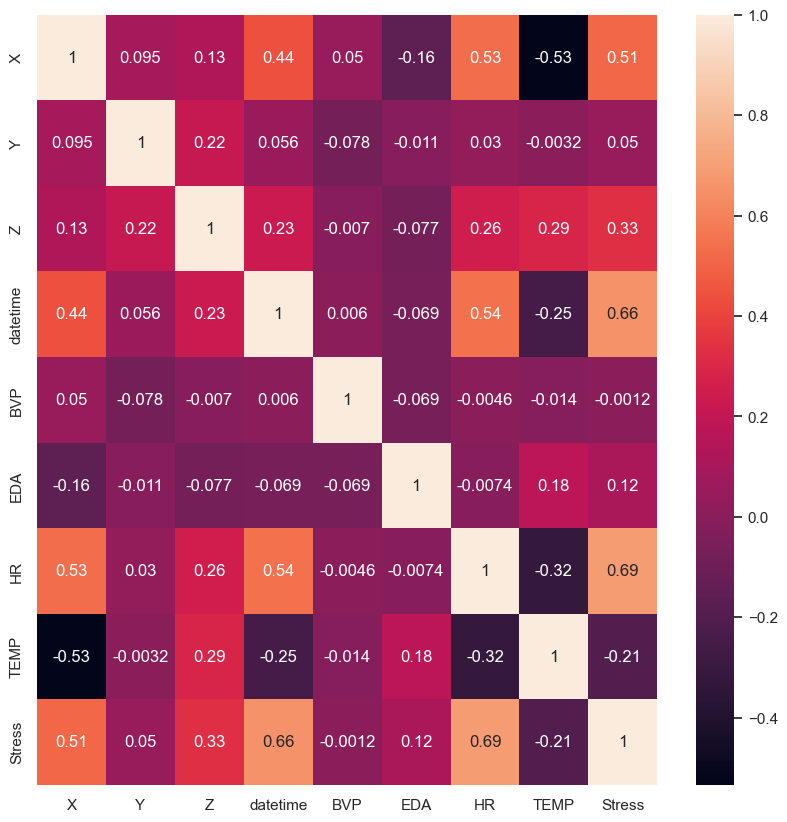

In [57]:
sns.set(rc={"figure.figsize":(10,10)})
sns.heatmap(final.corr(),annot = True)

# Time series

In [72]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

Text(0.5, 1.0, 'ACC')

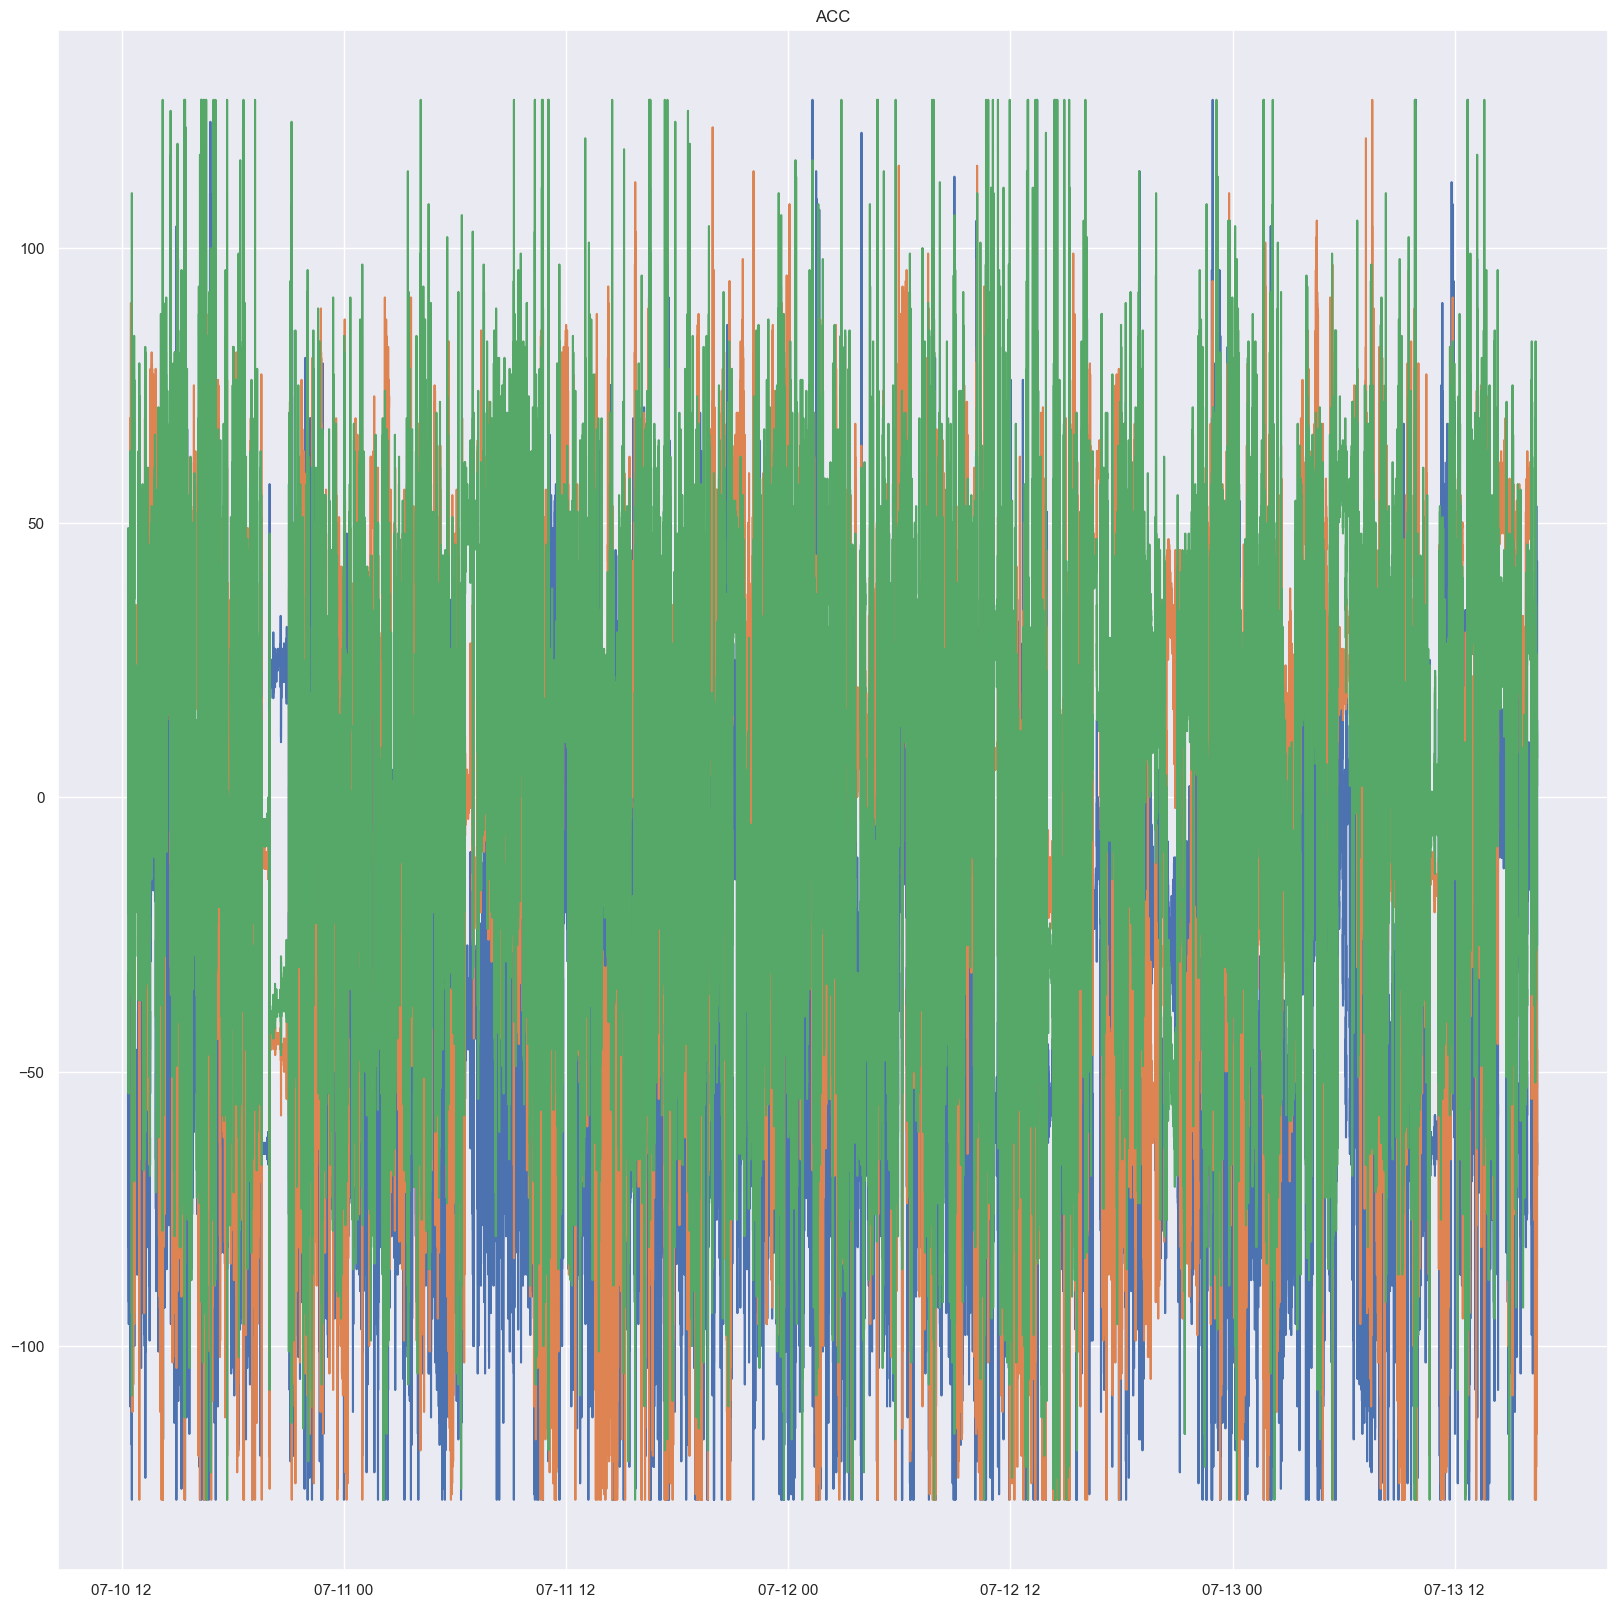

In [83]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot(final.time, final.X)
ax.plot(final.time, final.Y)
ax.plot(final.time, final.Z)
ax.set_title('ACC')

Text(0.5, 1.0, 'HEART RATE')

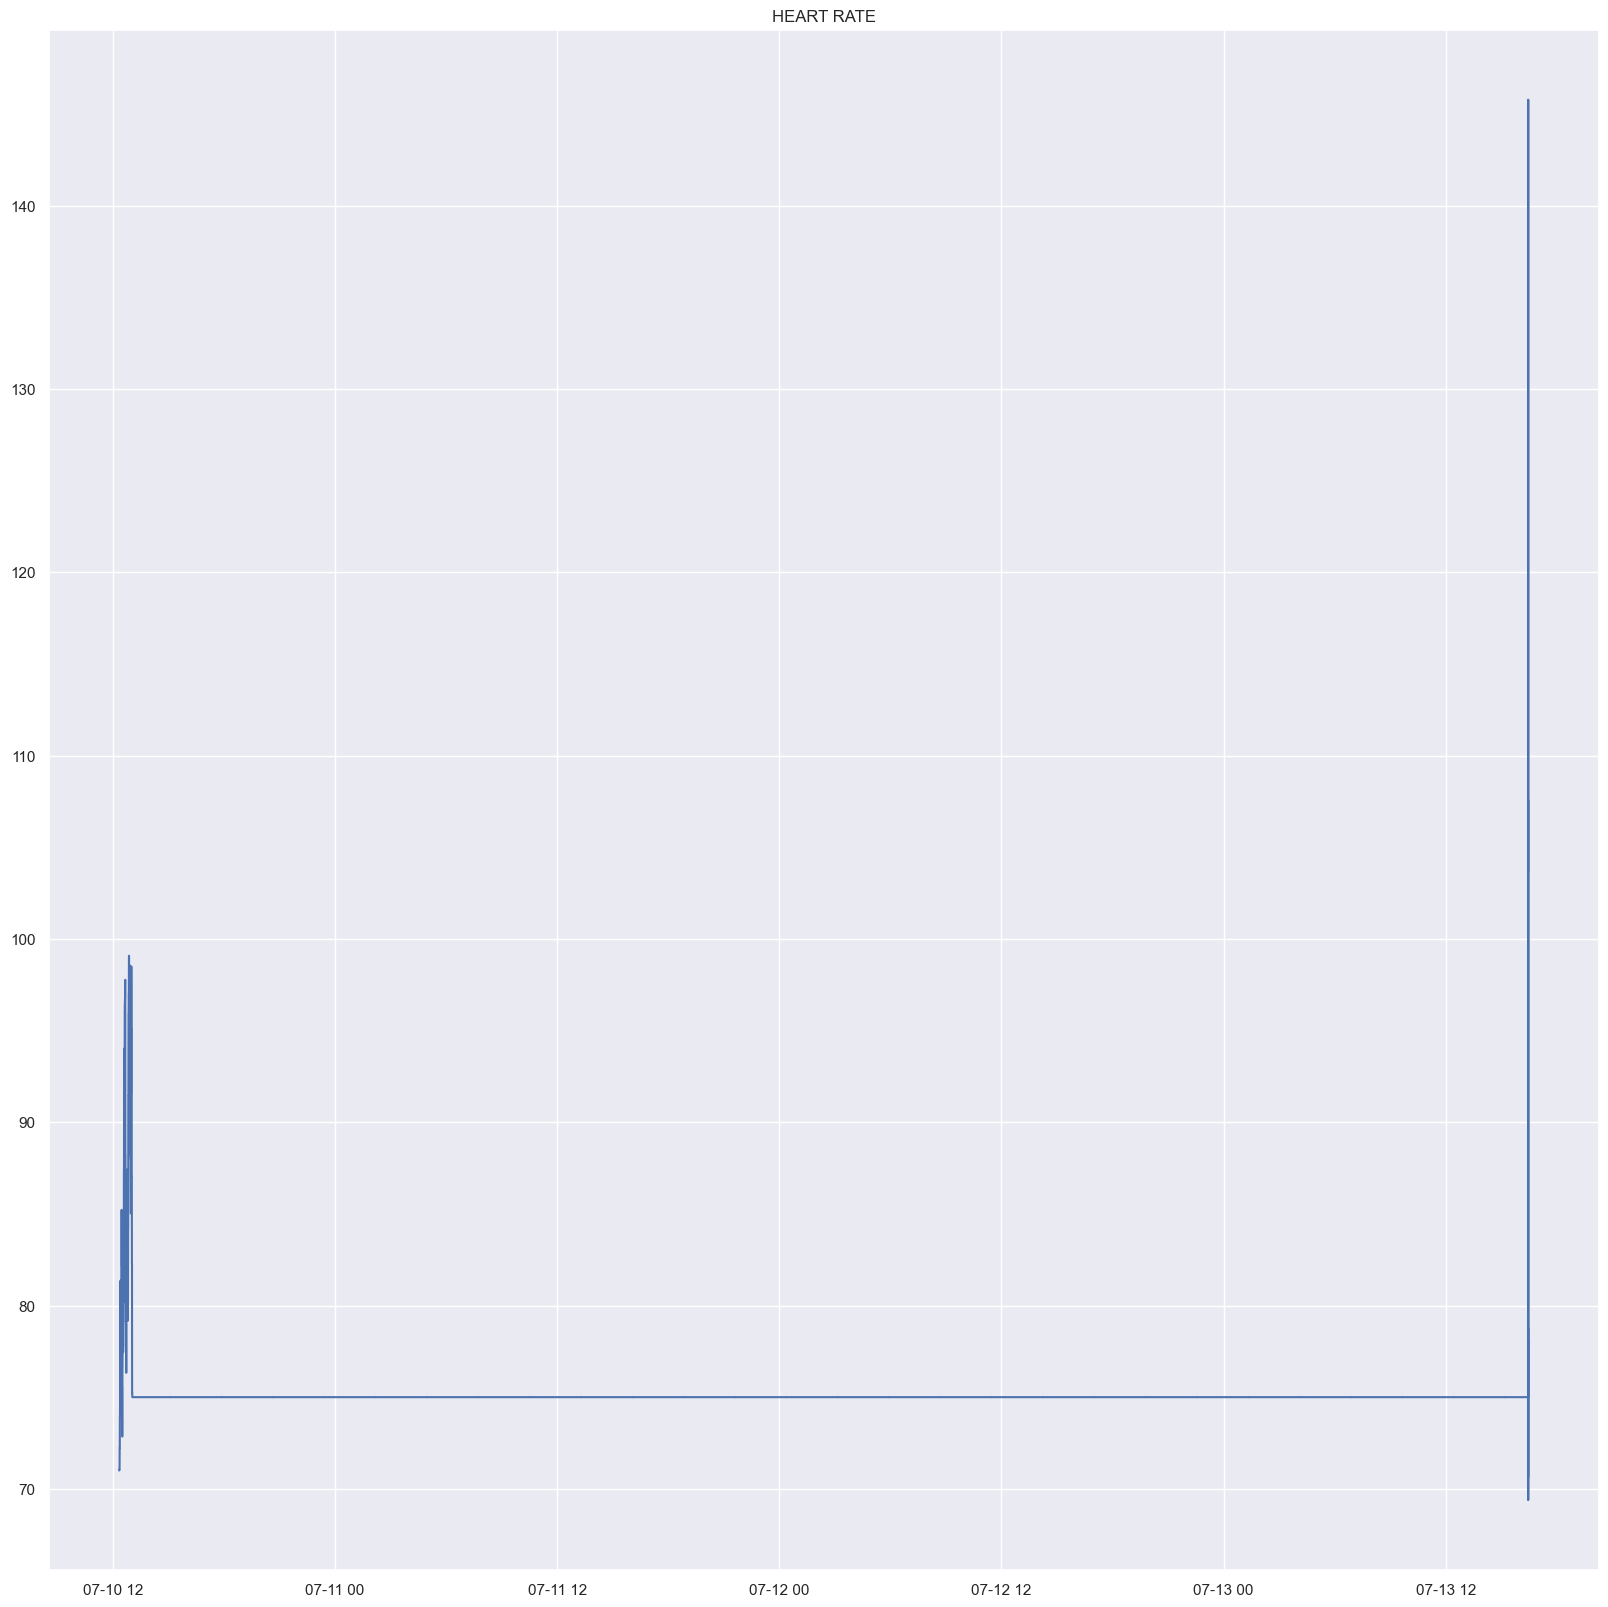

In [82]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot(final.time, final.HR)
ax.set_title('HEART RATE')

# Splitting the data

In [61]:
final.columns

Index(['X', 'Y', 'Z', 'time', 'datetime', 'BVP', 'EDA', 'HR', 'TEMP',
       'Stress'],
      dtype='object')

In [62]:
X = final.drop({'time','Stress','datetime'},axis = 1)
y = final['Stress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Model Building

In [63]:
#Logistic Regression

LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

In [64]:
model1 = LR.predict(X_test)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [65]:
print(classification_report(y_test, model1))

              precision    recall  f1-score   support

           1       0.85      0.88      0.87   1114072
           2       0.87      0.85      0.86   1113460

    accuracy                           0.86   2227532
   macro avg       0.86      0.86      0.86   2227532
weighted avg       0.86      0.86      0.86   2227532



In [66]:
#Naive Bayes

GNB = GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB()

In [67]:
model2 = GNB.predict(X_test)

In [68]:
print(classification_report(y_test, model2))

              precision    recall  f1-score   support

           1       0.86      0.92      0.89   1114072
           2       0.91      0.85      0.88   1113460

    accuracy                           0.88   2227532
   macro avg       0.88      0.88      0.88   2227532
weighted avg       0.88      0.88      0.88   2227532



In [69]:
#Random Forest

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
model3= RF.predict(X_test)

In [71]:
print(classification_report(y_test, model3))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99   1114072
           2       0.99      1.00      0.99   1113460

    accuracy                           0.99   2227532
   macro avg       0.99      0.99      0.99   2227532
weighted avg       0.99      0.99      0.99   2227532

